<a href="https://colab.research.google.com/github/AGrantHewitt/Classification-Modeling/blob/main/BioChemistry_Classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
#First choice: Crystal Structures Classification

filename = "/content/drive/MyDrive/Coding Dojo/Project 2/Crystal_structure.csv"
df = pd.read_csv(filename)
df.tail()

,Compound,A,B,In literature,v(A),v(B),r(AXII)(Å),r(AVI)(Å),r(BVI)(Å),EN(A),EN(B),l(A-O)(Å),l(B-O)(Å),ΔENR,tG,τ,μ,Lowest distortion
5324,ZrWO3,Zr,W,False,1,5,0.89,0.72,0.62,1.33,2.36,2.38342,1.745600,-1.572214,0.801621,5.228952455,0.442857,cubic
5325,ZrYO3,Zr,Y,False,-,-,0.89,0.72,0.90,1.33,1.22,2.38342,2.235124,-2.489571,0.704032,-,0.642857,cubic
5326,ZrYbO3,Zr,Yb,False,-,-,0.89,0.72,0.95,1.33,1.10,2.38342,2.223981,-2.626821,0.689053,-,0.678571,orthorhombic
5327,ZrZnO3,Zr,Zn,False,-,-,0.89,0.72,0.74,1.33,1.65,2.38342,2.096141,-2.035750,0.756670,-,0.528571,cubic
5328,Zr2O3,Zr,Zr,False,-,-,0.89,0.72,0.72,1.33,1.33,2.38342,2.043778,-2.097821,0.763809,-,0.514286,cubic


In [3]:
# 1) Source of data
#https://www.kaggle.com/datasets/sayansh001/crystal-structure-classification?select=Crystal_structure.csv

In [4]:
# 2) Brief description of data
# This dataset shows the numerous studies of perovskite structures. 
# An ideal perovskite has an ABX3 structure where A and B are two differently sized cations, and X is an anion. (This is not confined to one specific structure)
# Features such as electronegativity, ionic radius, valence, and bond lengths of A-O and B-O pairs have been identified that enable a priori crystal structure prediction. 
# Each observation is used to predict the crystal structure to be either a cubic, tetragonal, orthorhombic, or rhombohedral structure.

In [5]:
# 3) What is the target?
#Lowest Distortion 

In [6]:
# 4) Is this a classification or regression problem?
#Classification (Multi-Class)

In [7]:
# 5) How many features?
# 13

In [8]:
# 6) How many rows of data.
df.shape #5329 rows

(5329, 18)

In [9]:
# 7) What, if any, challenges do your foresee in cleaning, exploring, or modeling with this dataset?
#There are some missing values I will have to address. 
#This is a decent sized data set and I don't want to lose data that would make the model less efficient.
#For now the goal is to determine the different crystal structures but the challenge will be to determine which compounds have ideal structures.

In [10]:
#Column Dictionary
#Compound	 - The chemical formula of the compund 
#A	- element A
#B	- element B
#In literature - if the compund is found in literature
# v(A) - Valence of A
# v(B) - Valence of B
# Radius A (r(AXII)) - ionic radius of A cation
# Radius B (r(AVI)) - ionic radius of B cation
# Radius X (r(BVI)) - ionic radius of X anion (O3)
# Electronegativity of A (EN(A)) - Average electronegativity value of A cation
# Electronegativity of B (EN(B)) - Average electronegativity value of B cation
# l(A-O) - Bond length of A-O pair
# l(B-O) - Bond length of B-O pair
# ΔENR - Electronegativity difference with radius
# tG - Goldschmidt tolerance factor
# τ New tolerance factor
# μ - Octahedral factor
# Lowest Distortion - crystal structure

In [11]:
df_0 = df.copy() #original uncleaned dataset
#delete unnecessary columns
#I feel that "Compound" should be dropped. The A and B column state the two different elements and oxygen is in all the compounds so that becomes redundant.
#It is easier to determine the compund given the two elements and the structure.
#I also feel that "In Literature" is an unnessecary column. How will knowing if this compound is in literature help predict the structure? 
#It most likely won't. 
#All other columns are measurements within the compound that aid in determining the structure shape
df.drop(columns=["Compound","In literature"], inplace = True)

In [12]:
#delete duplicate rows
df.duplicated().sum()

0

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   A                  5329 non-null   object 
 1   B                  5329 non-null   object 
 2   v(A)               5329 non-null   object 
 3   v(B)               5329 non-null   object 
 4   r(AXII)(Å)         5329 non-null   float64
 5   r(AVI)(Å)          5329 non-null   float64
 6   r(BVI)(Å)          5329 non-null   float64
 7   EN(A)              5329 non-null   float64
 8   EN(B)              5329 non-null   float64
 9   l(A-O)(Å)          5329 non-null   float64
 10  l(B-O)(Å)          5329 non-null   float64
 11  ΔENR               5329 non-null   float64
 12  tG                 5329 non-null   float64
 13  τ                  5329 non-null   object 
 14  μ                  5329 non-null   float64
 15  Lowest distortion  5329 non-null   object 
dtypes: float64(10), object(6

In [14]:
#identify and addressed missing values 
df.isna().sum() 
#technically there are no missing values (NaN) but there are cells with a place holder (-)
#I am unsure if the dash will mess up the model.

(df == "-").sum()

#I am assuming that the valencies of a & b are missing for the same compund. 
# inputting each valency will take a long time and imputing causes errors in the data. 
# dropping the row will remove a lot of info from the data but 3000 rows is still good.
# I will first try dropping the rows, then the columns, then encoding to find the best result   
df = df[df['v(A)'] != '-']
df = df[df['v(B)'] != '-']

# I am also going to drop the tau colomn because more than half of the data is missing.
df.drop(columns="τ", inplace = True)

#I will leave the missing data as a new class in lower distortion. 
#with further investigation, maybe the model can determine what the structure is.

In [15]:
#identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats)
#the only categorical column in the target column "lowest distortion"
df["Lowest distortion"].value_counts()


cubic           2170
orthorhombic     968
rhombohedral     210
tetragonal        78
-                 22
Name: Lowest distortion, dtype: int64

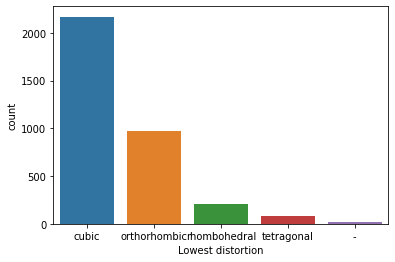

In [16]:
#produced univariate visuals for the target and all features
sns.countplot(data = df, x = df["Lowest distortion"]);
#the most common class is cubic. However this does not automatically mean it is the ideal structure.

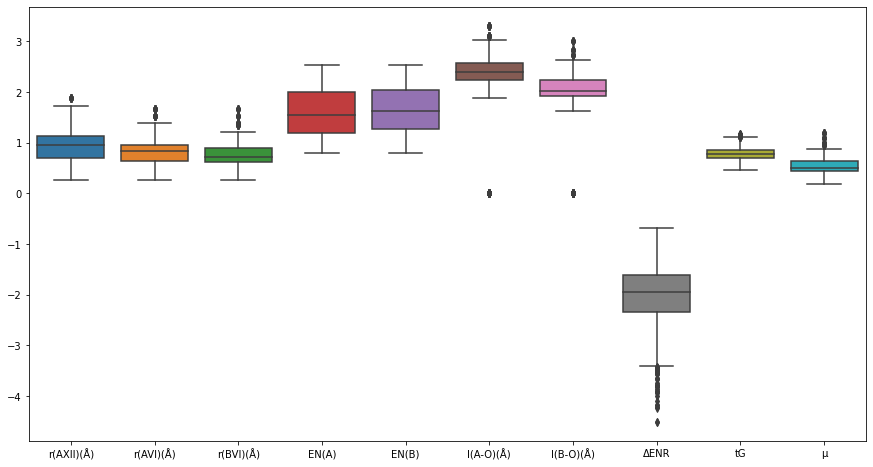

In [17]:
#identified outliers
plt.figure(figsize=(15,8))
sns.boxplot(data = df );

#I will delete the extreme outliers in the bond lengths and ENR columns

In [18]:
df = df[df['l(A-O)(Å)'] != 0]
df = df[df['l(B-O)(Å)'] != 0]
df = df[df['ΔENR'] > -3.8]

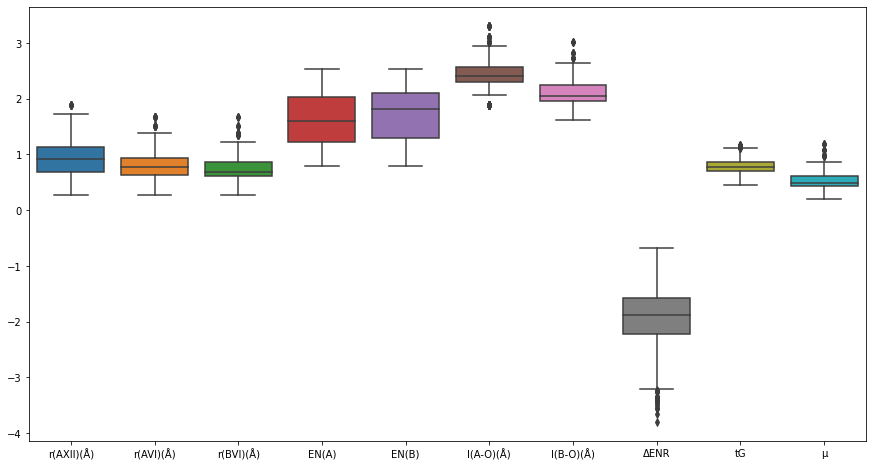

In [19]:
plt.figure(figsize=(15,8))
sns.boxplot(data = df );

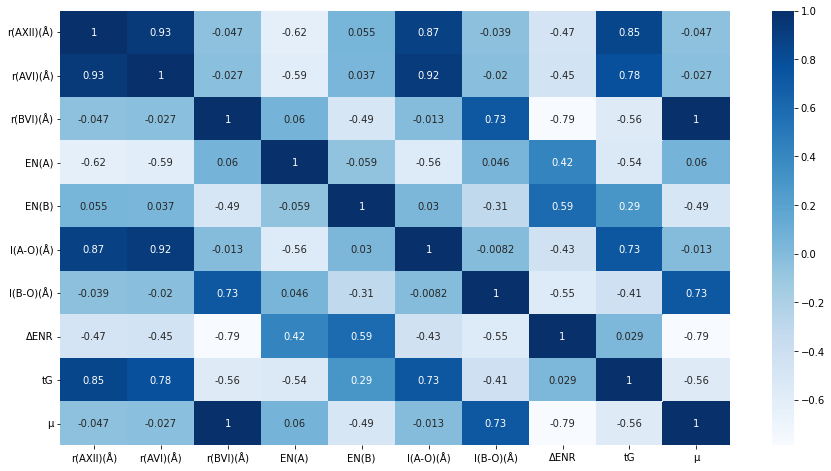

In [20]:
#produce a correlation heatmap and identify any moderate or strong correlations between your target and your features and/or between one feature and another
plt.figure(figsize=(15,8))
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True); 

#We see that Ionic radius of A cation [r(AXII)(Å)] and Ionic radius of B cation [r(AVI)(Å)] are postively correlated (0.94)
#We also see that the Ionic radius of X anion [r(BVI)(Å)] and the Octahedral factor [μ] are postively correlated (1)


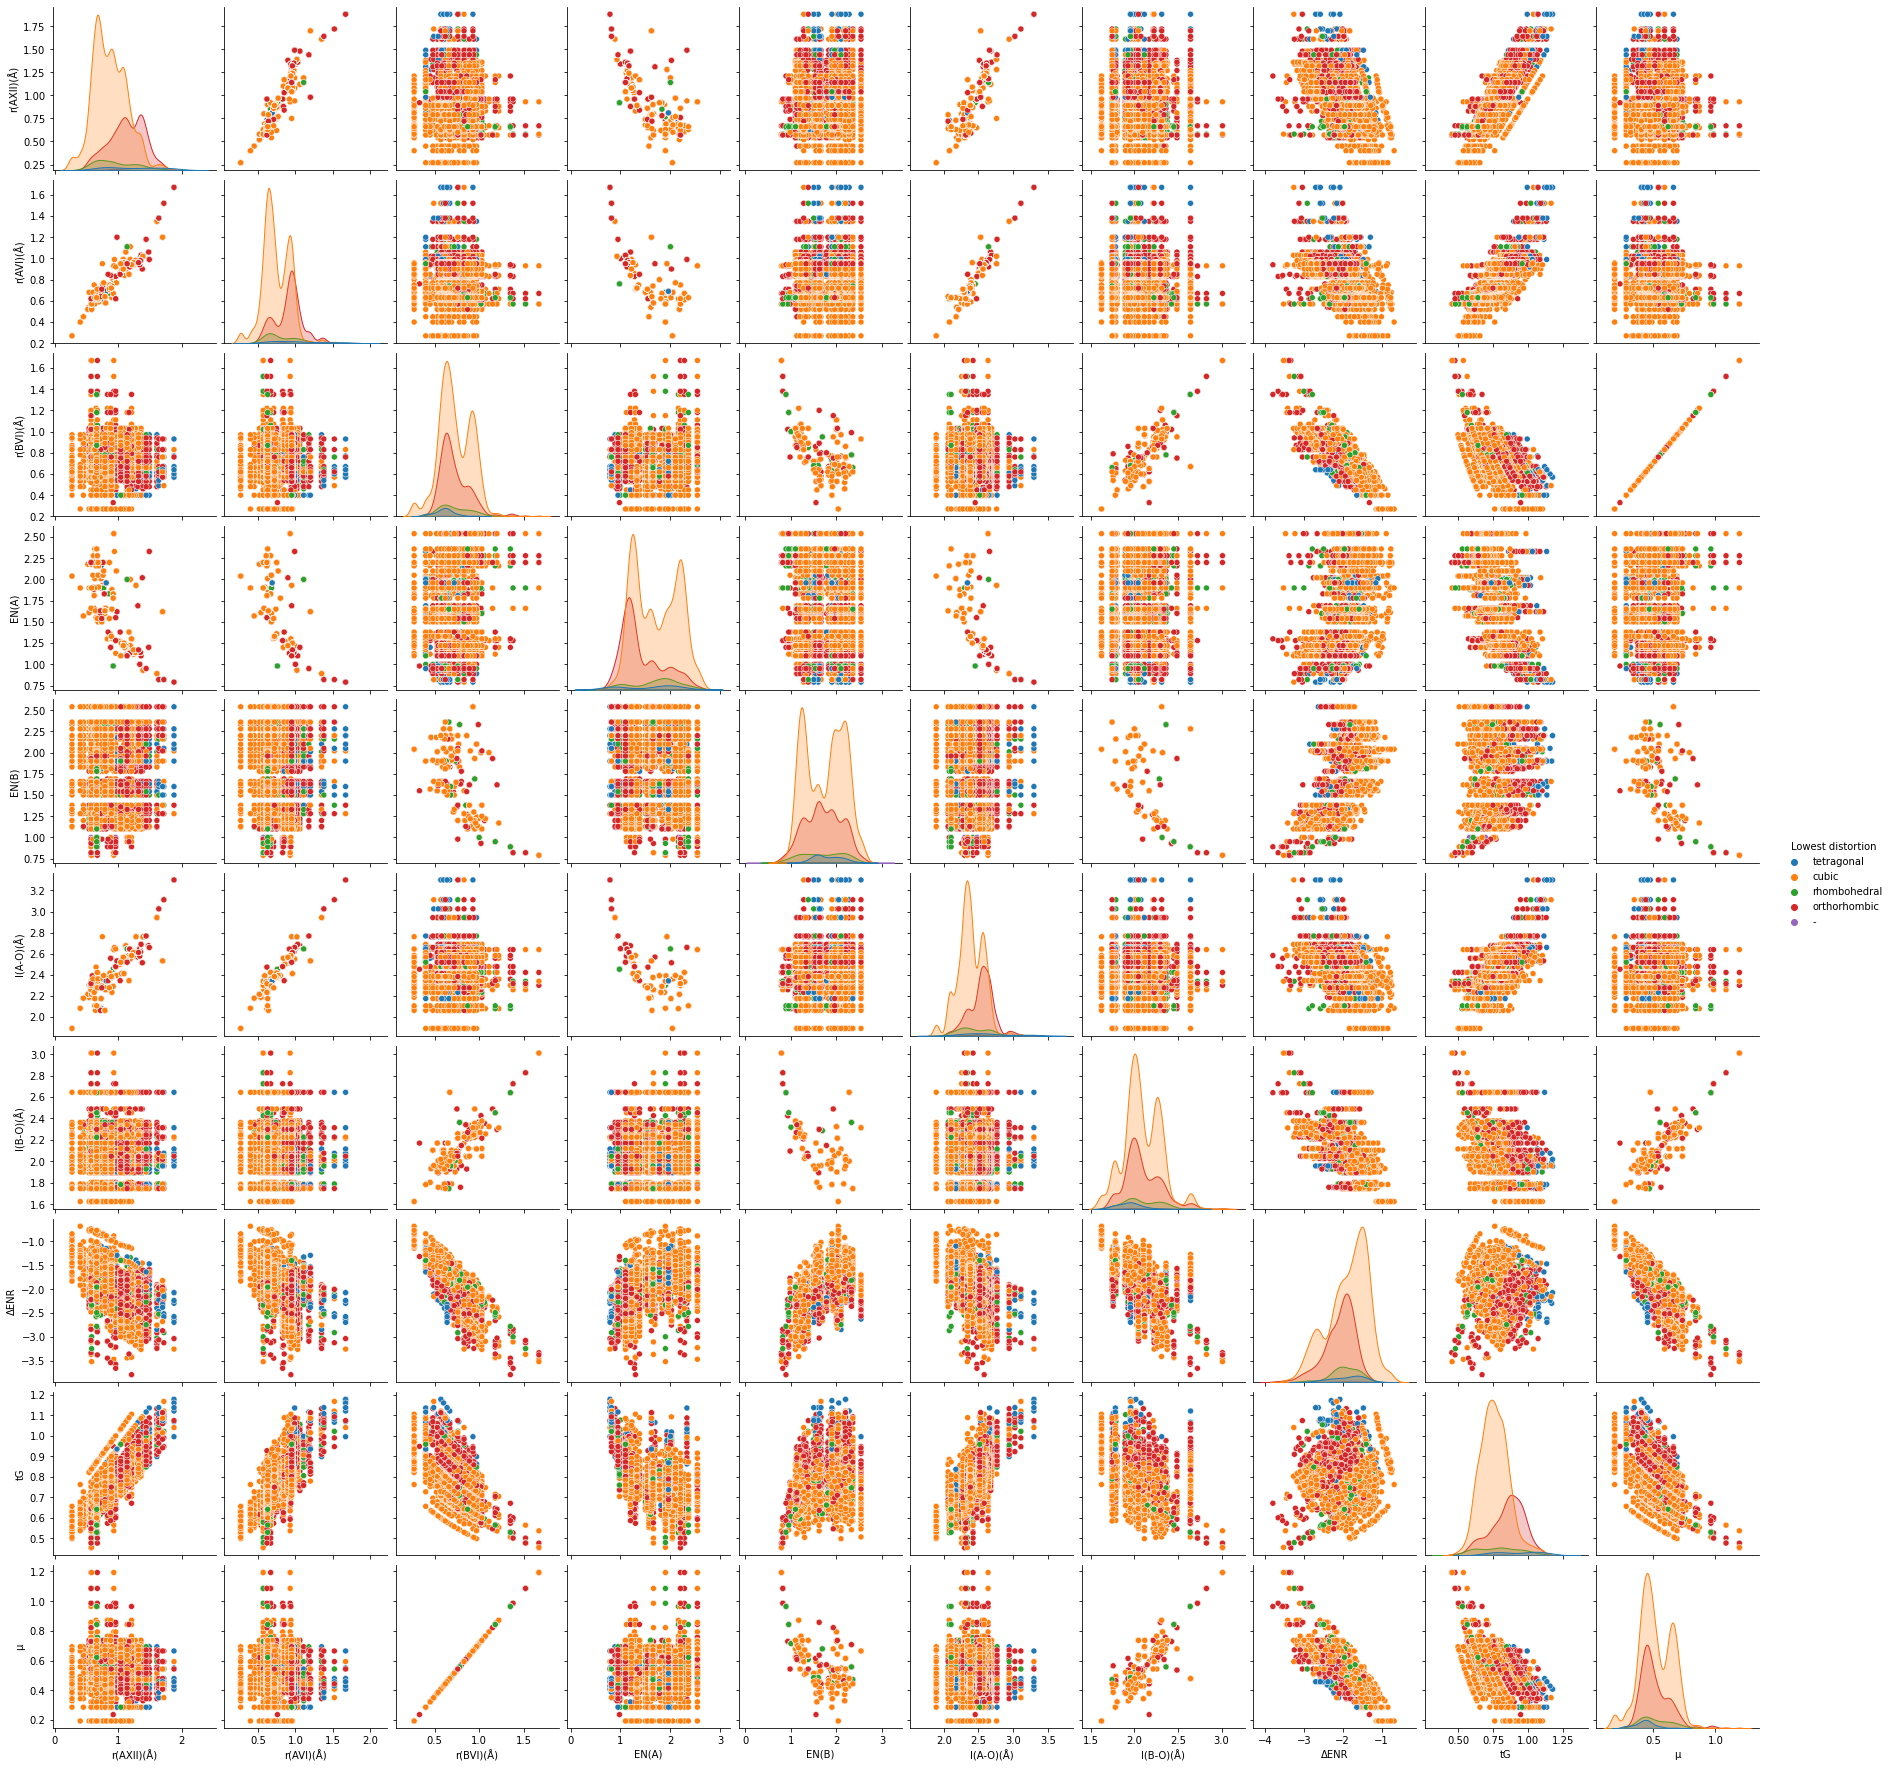

In [23]:
#Creating multivariate exploratory visuals to further understand your data
sns.pairplot(df, hue = "Lowest distortion");
#this shows the correlation plot but in scatter plot formation

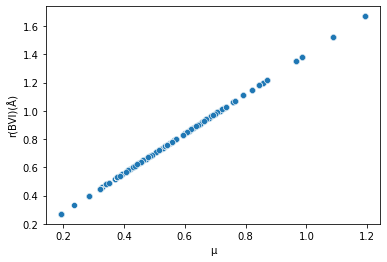

In [24]:
# From your data analysis, create two visuals that demonstrate key findings of interest to a stakeholder. 

sns.scatterplot(data = df, x =df['μ'] ,y= df['r(BVI)(Å)']);

#We see that x is the octahedral factor and y is the ionic radius of the A cation and they are completely postively correlated
#The octahedral factor is a parameter for predicting structure stability. When μ > 0.41, the structure is stable.
# so we see that all radii above 0.6 are most likely to have stable crystal structures.


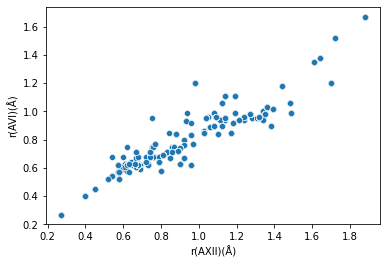

In [25]:
sns.scatterplot(data = df, x =df['r(AXII)(Å)'] ,y= df['r(AVI)(Å)']);    

#We see that x is the ionic radius of A cation and y is the ionic rdaius of the B cation and they are strongly positively correlated.
# From the previous graph we saw that all radii above 0.6 are most likely to have stablely structures.
# Thus we can infer that the A cations above 0.6 that correlate with the B cations will also have stable crystal structures